In [1]:
# Configure Live Reveal Slides
from notebook.services.config import ConfigManager
cm = ConfigManager()
_ = cm.update('livereveal', {
        'theme': 'serif',
        'transition': 'fade',
        'start_slideshow_at': 'selected',
        'slideNumber' : 'True',
        'progress' : 'True',
        'width': 1920,
        'height': 1080,
})

# LDA
## [Linear Discriminant Analysis](https://en.wikipedia.org/wiki/Linear_discriminant_analysis)

### [Wine Dataset](https://archive.ics.uci.edu/ml/datasets/Wine)
Lets take a look at the wine dataset first

In [4]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [5]:
names = ['Class', 'Alcohol', 'Malic Acid', 'Ash', 'Ash Alcalinity', 'Magnesium', 'Total Phenols', \
           'Flavanoids', 'Nonflavanoid Phenols', 'Proanthocyanins', 'Color Intensity', 'Hue', \
           'Dilution', 'Proline']
wine_path = 'wine.data'
wine_df = pd.read_csv(wine_path, names=names)

X = wine_df.drop('Class',axis=1).values
y = wine_df['Class'].values
label_dict = {1: 'Class 1', 2: 'Class 2', 3:'Class 3'}

Its got 3 classes, 13 features

## LDA approach in 5 steps

Listed below are the 5 general steps for performing a linear discriminant analysis; we will explore them in more detail in the following sections.

1. Compute the $d$-dimensional mean vectors for the different classes from the dataset.
2. Compute the scatter matrices (in-between-class and within-class scatter matrix).
3. Compute the eigenvectors ($\pmb e_1, \; \pmb e_2, \; ..., \; \pmb e_d$) and corresponding eigenvalues ($\pmb \lambda_1, \; \pmb \lambda_2, \; ..., \; \pmb \lambda_d$) for the scatter matrices.
4. Sort the eigenvectors by decreasing eigenvalues and choose $k$ eigenvectors with the largest eigenvalues to form a $k \times d$ dimensional matrix $\pmb W\;$ (where every column represents an eigenvector).
5. Use this $k \times d$ eigenvector matrix to transform the samples onto the new subspace. This can be summarized by the mathematical equation: $\pmb Y = \pmb X \times \pmb W$ (where $\pmb X$ is a $n \times d$-dimensional matrix representing the $n$ samples, and $\pmb y$ are the transformed $n \times k$-dimensional samples in the new subspace).

##  Step 1: Computing the Mean

In [6]:
np.set_printoptions(precision=4)


mean_vectors = []
for cl in range(1,3):
    mean_vectors.append(np.mean(X[y==cl], axis=0))
    print('Mean Vector class %s: %s\n' %(cl, mean_vectors[cl-1]))

Mean Vector class 1: [  1.3745e+01   2.0107e+00   2.4556e+00   1.7037e+01   1.0634e+02
   2.8402e+00   2.9824e+00   2.9000e-01   1.8993e+00   5.5283e+00
   1.0620e+00   3.1578e+00   1.1157e+03]

Mean Vector class 2: [  1.2279e+01   1.9327e+00   2.2448e+00   2.0238e+01   9.4549e+01
   2.2589e+00   2.0808e+00   3.6366e-01   1.6303e+00   3.0866e+00
   1.0563e+00   2.7854e+00   5.1951e+02]



##  Step 2: Computing the Scatter Matrices

Now, we will compute the two *4x4*-dimensional matrices: The within-class and the between-class scatter matrix.

### 2.1 Within-class scatter matrix $S_W$

The **within-class scatter** matrix $S_W$ is computed by the following equation:  

$S_W = \sum\limits_{i=1}^{c}  S_i$

where  
$S_i = \sum\limits_{\pmb x \in D_i}^n (\pmb x - \pmb m_i)\;(\pmb x - \pmb m_i)^T$  
(scatter matrix for every class) 

and $\pmb m_i$ is the mean vector    
$\pmb m_i = \frac{1}{n_i} \sum\limits_{\pmb x \in D_i}^n \; \pmb x_k$

In [7]:
S_W = np.zeros((13,13))
for cl,mv in zip(range(1,2), mean_vectors):
    class_sc_mat = np.zeros((13,13))                  # scatter matrix for every class
    for row in X[y == cl]:
        row, mv = row.reshape(13,1), mv.reshape(13,1) # make column vectors
        class_sc_mat += (row-mv).dot((row-mv).T)
    S_W += class_sc_mat                             # sum class scatter matrices
print('within-class Scatter Matrix:\n', S_W)

('within-class Scatter Matrix:\n', array([[  1.2386e+01,  -7.4769e-01,  -9.0477e-01,  -2.1728e+01,
          4.4845e+01,   3.8221e+00,   4.4204e+00,   2.9400e-02,
          3.3974e+00,   1.3554e+01,   2.4983e-01,   6.6822e-01,
          2.1413e+03],
       [ -7.4769e-01,   2.7498e+01,   2.3788e-01,   6.1045e+00,
          3.3256e+01,  -1.1305e+00,  -3.0364e+00,  -2.5000e-01,
         -1.3298e+00,  -1.2741e+01,  -1.9537e+00,   2.4705e+00,
         -3.2965e+03],
       [ -9.0477e-01,   2.3788e-01,   2.9931e+00,   1.8430e+01,
          5.2918e+01,   2.1444e-02,  -3.6898e-01,   4.3000e-01,
         -7.8988e-01,  -2.0271e+00,   3.6713e-01,  -3.8387e-01,
         -8.6175e+01],
       [ -2.1728e+01,   6.1045e+00,   1.8430e+01,   3.7606e+02,
          3.6955e+02,  -1.1163e+01,  -1.6854e+01,   3.1270e+00,
         -1.0568e+01,  -3.8587e+01,   1.5995e+00,  -6.2072e+00,
         -4.0056e+03],
       [  4.4845e+01,   3.3256e+01,   5.2918e+01,   3.6955e+02,
          6.3932e+03,   6.3417e+01,   2.9

### 2.2 Between-class scatter matrix $S_B$


The **between-class scatter** matrix $S_B$ is computed by the following equation:  

$S_B =  \sum\limits_{i=1}^{c} N_{i} (\pmb m_i - \pmb m) (\pmb m_i - \pmb m)^T$

where  
 $\pmb m$ is the overall mean, and $\pmb m_{i}$ and $N_{i}$ are the sample mean and sizes of the respective classes.

In [8]:
overall_mean = np.mean(X, axis=0)

S_B = np.zeros((13,13))
for i,mean_vec in enumerate(mean_vectors):  
    n = X[y==i+1,:].shape[0]
    mean_vec = mean_vec.reshape(13,1) # make column vector
    overall_mean = overall_mean.reshape(13,1) # make column vector
    S_B += n * (mean_vec - overall_mean).dot((mean_vec - overall_mean).T)
    
print('between-class Scatter Matrix:\n', S_B)

('between-class Scatter Matrix:\n', array([[  6.9669e+01,   6.3917e+00,   1.0150e+01,  -1.4599e+02,
          5.5577e+02,   2.5787e+01,   3.9201e+01,  -3.2473e+00,
          1.1522e+01,   1.2169e+02,  -4.7391e-01,   1.5075e+01,
          2.7847e+04],
       [  6.3917e+00,   1.7827e+01,   1.7773e+00,   2.5925e+01,
          2.2048e+01,  -9.4344e+00,  -1.9792e+01,   1.3288e+00,
         -7.0550e+00,   4.7469e+01,  -4.8421e+00,  -1.5471e+01,
         -5.6963e+02],
       [  1.0150e+01,   1.7773e+00,   1.5202e+00,  -1.9338e+01,
          7.9548e+01,   3.1778e+00,   4.5633e+00,  -3.9326e-01,
          1.2805e+00,   1.9510e+01,  -3.0453e-01,   1.3691e+00,
          3.9036e+03],
       [ -1.4599e+02,   2.5925e+01,  -1.9338e+01,   3.9557e+02,
         -1.2306e+03,  -8.0946e+01,  -1.3548e+02,   1.0514e+01,
         -4.2644e+01,  -1.7219e+02,  -9.9506e+00,  -7.0025e+01,
         -6.5476e+04],
       [  5.5577e+02,   2.2048e+01,   7.9548e+01,  -1.2306e+03,
          4.4822e+03,   2.2552e+02,   3.

## Step 3: Solving the generalized eigenvalue problem for the matrix $S_{W}^{-1}S_B$

In [10]:
eig_vals, eig_vecs = np.linalg.eig(np.linalg.inv(S_W).dot(S_B))

for i in range(len(eig_vals)):
    eigvec_sc = eig_vecs[:,i].reshape(13,1)   
    print('\nEigenvector {}: \n{}'.format(i+1, eigvec_sc.real))
    print('Eigenvalue {:}: {:.2e}'.format(i+1, eig_vals[i].real))


Eigenvector 1: 
[[ -5.5178e-02]
 [  3.1206e-03]
 [ -1.2575e-01]
 [  3.9878e-03]
 [  5.0861e-03]
 [  3.1920e-02]
 [  4.1967e-01]
 [ -7.0028e-01]
 [ -3.4561e-02]
 [ -1.5102e-01]
 [  5.2378e-01]
 [  1.2338e-01]
 [  3.5312e-04]]
Eigenvalue 1: 2.83e+01

Eigenvector 2: 
[[  2.2406e-01]
 [  3.4697e-02]
 [  5.0655e-01]
 [ -2.1474e-02]
 [  1.7723e-03]
 [ -3.6466e-01]
 [  1.0518e-01]
 [ -2.5237e-01]
 [ -3.4118e-02]
 [  4.4911e-02]
 [ -6.8830e-01]
 [  8.2842e-02]
 [  4.2190e-04]]
Eigenvalue 2: 1.23e+01

Eigenvector 3: 
[[ 0.2498]
 [-0.1492]
 [ 0.0297]
 [ 0.0398]
 [-0.0043]
 [ 0.2048]
 [ 0.1659]
 [-0.2307]
 [-0.1877]
 [ 0.0824]
 [ 0.5917]
 [-0.174 ]
 [-0.0009]]
Eigenvalue 3: 2.68e-15

Eigenvector 4: 
[[ 0.2498]
 [-0.1492]
 [ 0.0297]
 [ 0.0398]
 [-0.0043]
 [ 0.2048]
 [ 0.1659]
 [-0.2307]
 [-0.1877]
 [ 0.0824]
 [ 0.5917]
 [-0.174 ]
 [-0.0009]]
Eigenvalue 4: 2.68e-15

Eigenvector 5: 
[[ 0.3683]
 [-0.1561]
 [ 0.0241]
 [ 0.0501]
 [ 0.0019]
 [ 0.5136]
 [-0.1162]
 [-0.5911]
 [-0.1071]
 [-0.0117]
 [ 0.38


A quick check that the eigenvector-eigenvalue calculation is correct and satisfy the equation:

$\pmb A\pmb{v} =  \lambda\pmb{v}$  

<br>
where  
$\pmb A = S_{W}^{-1}S_B\\
\pmb{v} = \; \text{Eigenvector}\\
\lambda = \; \text{Eigenvalue}$

In [11]:
for i in range(len(eig_vals)):
    eigv = eig_vecs[:,i].reshape(13,1) 
    np.testing.assert_array_almost_equal(np.linalg.inv(S_W).dot(S_B).dot(eigv), 
                                         eig_vals[i] * eigv, 
                                         decimal=6, err_msg='', verbose=True)
print('ok')

ok


### 4.1. Sorting the eigenvectors by decreasing eigenvalues

In [12]:
# Make a list of (eigenvalue, eigenvector) tuples
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eig_pairs = sorted(eig_pairs, key=lambda k: k[0], reverse=True)

# Visually confirm that the list is correctly sorted by decreasing eigenvalues

print('Eigenvalues in decreasing order:\n')
for i in eig_pairs:
    print(i[0])

Eigenvalues in decreasing order:

28.2836470112
12.2706915091
3.40961784481e-15
3.40961784481e-15
3.13831423828e-15
2.02306246314e-15
2.02306246314e-15
1.24951340812e-15
1.24951340812e-15
1.22432703145e-15
7.09189182161e-16
7.09189182161e-16
4.10048955759e-16


In [13]:
print('Variance explained:\n')
eigv_sum = sum(eig_vals)
for i,j in enumerate(eig_pairs):
    print('eigenvalue {0:}: {1:.2%}'.format(i+1, (j[0]/eigv_sum).real))

Variance explained:

eigenvalue 1: 69.74%
eigenvalue 2: 30.26%
eigenvalue 3: 0.00%
eigenvalue 4: 0.00%
eigenvalue 5: 0.00%
eigenvalue 6: 0.00%
eigenvalue 7: 0.00%
eigenvalue 8: 0.00%
eigenvalue 9: 0.00%
eigenvalue 10: 0.00%
eigenvalue 11: 0.00%
eigenvalue 12: 0.00%
eigenvalue 13: 0.00%


### 4.2. Choosing *k* eigenvectors with the largest eigenvalues

In [14]:
W = np.hstack((eig_pairs[0][1].reshape(13,1), eig_pairs[1][1].reshape(13,1)))
print('Matrix W:\n', W.real)

('Matrix W:\n', array([[ -5.5178e-02,   2.2406e-01],
       [  3.1206e-03,   3.4697e-02],
       [ -1.2575e-01,   5.0655e-01],
       [  3.9878e-03,  -2.1474e-02],
       [  5.0861e-03,   1.7723e-03],
       [  3.1920e-02,  -3.6466e-01],
       [  4.1967e-01,   1.0518e-01],
       [ -7.0028e-01,  -2.5237e-01],
       [ -3.4561e-02,  -3.4118e-02],
       [ -1.5102e-01,   4.4911e-02],
       [  5.2378e-01,  -6.8830e-01],
       [  1.2338e-01,   8.2842e-02],
       [  3.5312e-04,   4.2190e-04]]))


# Step 5: Transforming the samples onto the new subspace

In the last step, we use the $4 \times 2$-dimensional matrix $\pmb W$ that we just computed to transform our samples onto the new subspace via the equation   

$\pmb Y = \pmb X \times \pmb W $.

(where $\pmb X$ is a $n \times d$-dimensional matrix representing the $n$ samples, and $\pmb Y$ are the transformed $n \times k$-dimensional samples in the new subspace).

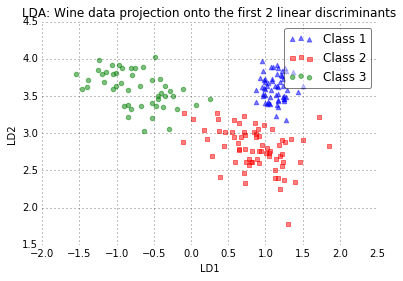

In [15]:
X_lda = X.dot(W)
from matplotlib import pyplot as plt

def plot_step_lda():
    
    ax = plt.subplot(111)
    for label,marker,color in zip(
        range(1,4),('^', 's', 'o'),('blue', 'red', 'green')):

        plt.scatter(x=X_lda[:,0].real[y == label],
                y=X_lda[:,1].real[y == label],
                marker=marker,
                color=color,
                alpha=0.5,
                label=label_dict[label]
                )

    plt.xlabel('LD1')
    plt.ylabel('LD2')

    leg = plt.legend(loc='upper right', fancybox=True)
    leg.get_frame().set_alpha(0.5)
    plt.title('LDA: Wine data projection onto the first 2 linear discriminants')
    
    # hide axis ticks
    plt.tick_params(axis="both", which="both", bottom="off", top="off",  
            labelbottom="on", left="off", right="off", labelleft="on")

    # remove axis spines
    ax.spines["top"].set_visible(False)  
    ax.spines["right"].set_visible(False) 
    ax.spines["bottom"].set_visible(False) 
    ax.spines["left"].set_visible(False)    
 
    plt.grid()
    plt.tight_layout
    plt.show()
    
plot_step_lda()

In [16]:
from sklearn.decomposition import PCA as sklearnPCA

sklearn_pca = sklearnPCA(n_components=2)
X_pca = sklearn_pca.fit_transform(X)

def plot_pca():

    ax = plt.subplot(111)
    
    for label,marker,color in zip(
        range(1,4),('^', 's', 'o'),('blue', 'red', 'green')):

        plt.scatter(x=X_pca[:,0][y == label],
                y=X_pca[:,1][y == label],
                marker=marker,
                color=color,
                alpha=0.5,
                label=label_dict[label]
                )

    plt.xlabel('PC1')
    plt.ylabel('PC2')

    leg = plt.legend(loc='upper right', fancybox=True)
    leg.get_frame().set_alpha(0.5)
    plt.title('PCA: Wine data projection onto the first 2 principal components')

    # hide axis ticks
    plt.tick_params(axis="both", which="both", bottom="off", top="off",  
            labelbottom="on", left="off", right="off", labelleft="on")

    # remove axis spines
    ax.spines["top"].set_visible(False)  
    ax.spines["right"].set_visible(False) 
    ax.spines["bottom"].set_visible(False) 
    ax.spines["left"].set_visible(False)    
    
    plt.tight_layout
    plt.grid()
    
    plt.show()

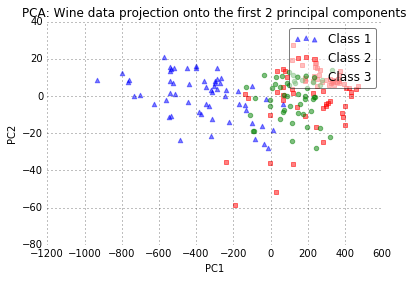

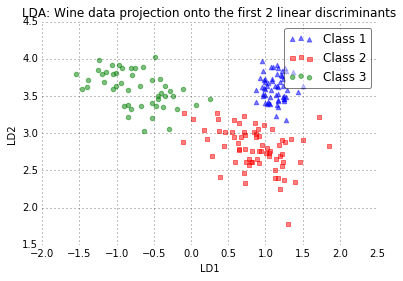

In [17]:
plot_pca()
plot_step_lda()